# Project 2 

The framework should import only torch.empty, and use no pre-existing neural-network python toolbox. Your code should work with autograd globally off, which can be achieved with torch . set˙grad˙enabled ( False )

In [1]:
import math
import torch 
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)

### Build the data

Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]², each with a label 0 if outside the disk centered at (0.5, 0.5) of radius 1/sqrt(2π), and 1 inside.

In [2]:
def build_data(n):
       
    x = torch.empty(n, 2) #(n,2)
    x = x.uniform_(0, 1)
    
    x_centered = x - 0.5
    norm_squared = x_centered.pow(2).sum(dim=1)  #(n,)
    
    r_squared = 1/ (2*math.pi)
    
    y = norm_squared.sub(r_squared).sign().add(1).div(2)
    return x, y

In [3]:
X_train, y_train = build_data(1000)  #(1000,2) , #(1000)
X_test, y_test = build_data(1000)  #(1000,2) , #(1000)

In [4]:
x = X_train[:,0]
y = X_train[:,1]
colors = { 1.0 : 'g', 0 : 'y'}

In [5]:
c = [ colors[label] for label in y_train.numpy()]

In [6]:
def one_hot_encoding(target):
    encoded = torch.empty(target.shape[0], 2)
    for i in range(target.shape[0]): 
        if(target[i]):
            encoded[i,0] = 0
            encoded[i,1] = target[i]
        else : 
            encoded[i,0] = 1
            encoded[i,1] = target[i]
    return encoded

In [7]:
encoded_y_train = one_hot_encoding(y_train)
encoded_y_test = one_hot_encoding(y_test)

### Visualize the data

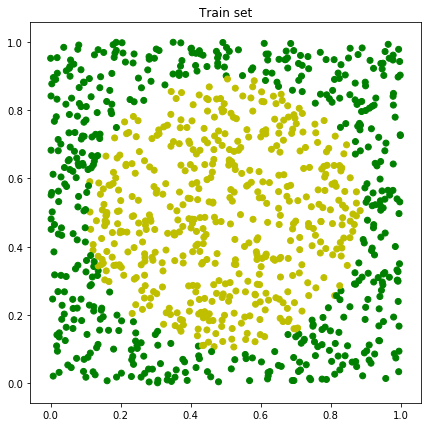

In [8]:
import matplotlib.pyplot as plt  # This is python's popular plotting library.

plt.figure(figsize=(7,7))
plt.scatter(x, y, c = c)
plt.title('Train set')
plt.show()

### Build the network

In [9]:
from linear import Linear
from sequential import Sequential

from activation_function.tanh import Tanh
from activation_function.sigmoid import Sigmoid
from activation_function.relu import ReLU
from activation_function.leakyReLu import LeakyReLU

from optimizer.sgd import SGD
from optimizer.momentum_sgd import MomentumSGDOptimizer

from loss.mse import MSELoss
from loss.cross import CrossEntropyLoss

In [10]:
def predict(model, X_test, y_test, mini_batch_size):
    
    criterion = MSELoss(model)
    
    number_batches =  X_train.size(0) // mini_batch_size

    #one hot encoding 
    encoded_y_test = one_hot_encoding(y_test)
    
    total_loss = 0
    total_acc = 0
    
    for index in range(0, X_test.size(0), mini_batch_size):
        X_test_batched = X_test[index:(index+mini_batch_size)]
            
        y_test_batched = y_test[index:(index+mini_batch_size)]
        y_test_encoded_batched = encoded_y_test[index:(index+mini_batch_size)]
        
        #forward pass
        output = model.forward(X_test_batched)
        loss = criterion.forward(output, y_test_encoded_batched)
        total_loss += loss.item() 
        
        batch_acc =  (output.max(1)[1].float() == y_test_batched).sum()
        total_acc += batch_acc.item()
    
    total_loss = total_loss / number_batches
    
    print('Obtain on the test set an average loss of {0} and an accuracy of {1}'.format(total_loss,total_acc))

In [16]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, mini_batch_size , 
                lr = 0.01, momentum = 0.9):
    
    total_loss = []
    total_acc = []
    
    criterion = MSELoss(model)
    optimizer = MomentumSGDOptimizer(model, lr, momentum)
    
    #one hot encoding 
    encoded_y_train = one_hot_encoding(y_train)
    
    number_batches =  X_train.size(0) // mini_batch_size
    
    for epoch in range(epochs):
        
        loss_epoch = 0
        acc_epoch = 0
        pred = []
        
        for index in range(0, X_train.size(0), mini_batch_size):
            X_train_batched = X_train[index:(index+mini_batch_size)]
            
            y_train_batched = y_train[index:(index+mini_batch_size)]
            y_train_encoded_batched = encoded_y_train[index:(index+mini_batch_size)]
            
            #forward pass
            output = model.forward(X_train_batched)
            loss = criterion.forward(output, y_train_encoded_batched)
            loss_epoch += loss.item() 
            
            #batch_acc = ((output.round() == y_train_encoded_batched_).sum(1) == 2).sum(0)
            batch_acc =  (output.max(1)[1].float() == y_train_batched).sum()
            acc_epoch += batch_acc
            
            #backward pass and update parameters gradient
            criterion.backward()  
            #update parameters
            optimizer.step()
        
        total_acc.append(acc_epoch)
        total_loss.append(loss_epoch / number_batches)
        
        #compute the predictions on the test set for this epoch model
        pred.append(predict(model, X_test, y_test, mini_batch_size))

    return model, total_loss, total_acc, pred

In [20]:
input_units = 2
hidden_units = 25
output_units = 2

model = Sequential(
            Linear(input_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, hidden_units),
            LeakyReLU(),
            Linear(hidden_units, output_units),
            Sigmoid()
)

In [25]:
epochs = 20
mini_batch_size = 5
model_trained, loss_epoch, total_acc, pred=  train_model(model, X_train, y_train, X_test, y_test,
                                                         epochs, mini_batch_size , lr = 0.01)

Obtain on the test set an average loss of 0.05488118051773256 and an accuracy of 961
Obtain on the test set an average loss of 0.059203489299470675 and an accuracy of 959
Obtain on the test set an average loss of 0.05624607311504761 and an accuracy of 962
Obtain on the test set an average loss of 0.054536477283536444 and an accuracy of 967
Obtain on the test set an average loss of 0.053558381974895396 and an accuracy of 965
Obtain on the test set an average loss of 0.04706394694108539 and an accuracy of 968
Obtain on the test set an average loss of 0.04807891334651646 and an accuracy of 968
Obtain on the test set an average loss of 0.051710365905928056 and an accuracy of 963
Obtain on the test set an average loss of 0.05457280314556142 and an accuracy of 963
Obtain on the test set an average loss of 0.07699637372666726 and an accuracy of 948
Obtain on the test set an average loss of 0.05540914759834667 and an accuracy of 963
Obtain on the test set an average loss of 0.05195508878282313

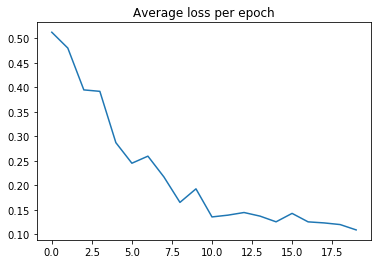

In [22]:
plt.plot(loss_epoch)
plt.title('Average loss per epoch')
plt.show()

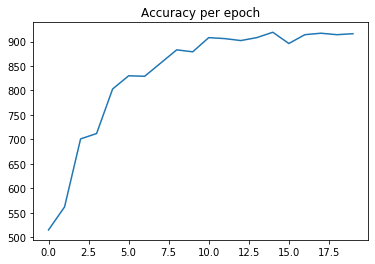

In [23]:
plt.plot(total_acc)
plt.title('Accuracy per epoch')
plt.show()

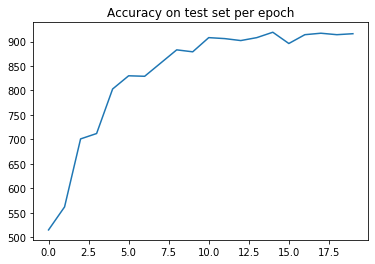

In [24]:
plt.plot(total_acc)
plt.title('Accuracy on test set per epoch')
plt.show()

## Pytorch

In [ ]:
import torch.nn as nn

torch.set_grad_enabled(True)

model_torch = nn.Sequential(
            nn.Linear(input_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_units),
            nn.Sigmoid()
)

In [ ]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 1e-1

    for e in range(25):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
        print(e, sum_loss)
    
    return model

def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [ ]:
#one hot encoding 
encoded_y_train = one_hot_encoding(y_train)

In [ ]:
train_model(model_torch, X_train, encoded_y_train, 5)

In [ ]:
compute_nb_errors(model, input, target, mini_batch_size)